# 11 - Porosity-Permeability Relationships Using Linear Regression in Python  
  
**Created By:** Andy McDonald  
**Link to Article:** 
  
Core data analysis is a key component in the evaluation of a field or discovery, as it provides direct samples of the geological formations in the subsurface over the interval of interest. It is often considered the 'ground truth' by many and is used as a reference for calibrating well log measurements and petrophysical analysis. Core data is expensive to obtain and not acquired on every well at every depth. Instead, it may be acquired at discrete intervals on a small number of wells within a field and then used as a reference for other wells.  
  
Once the core data has been extracted from the well it is taken to a lab to be analysed. Along the length of the retrieved core sample a number of measurements are made. Two of which are porosity and permeability, both key components of a petrophysical analysis.

**Porosity** is defined as the volume of space between the solid grains relative to the total rock volume. It provides an indication of the potential storage space for hydrocarbons. 
  
**Permeability** provides an indication of how easy fluids can flow through the rock.

Porosity is a key control on permeability, with larger pores resulting in wider pathways for the reservoir fluids to flow through.  
  
Well logging tools do not provide a direct measurement for permeability and therefore it has to be inferred through relationships with core data from the same field or well, or from empirically derived equations.  
  
One common method is to plot porosity (on a linear scale) against permeability (on a logarithmic scale) and observe the trend. From this, a regression can be applied to the porosity permeability (poro-perm) crossplot to derive an equation, which can subsequently be used to predict a continuous permeability from a computed porosity in any well.

To begin, we will import a number of common libraries before we start working with the actual data. For this article we will be using pandas, matplotlib and numpy. These three libraries allow us to load, work with and visualise our data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The dataset we are using comes from the publicly available Equinor Volve Field dataset released in 2018. This file is from 15/9- 19A which contained full regular core analysis data. To load this data in we can use pd.read_csv and pass in the file name.  
  
This dataset has already been depth aligned to well log data, so no adjustments to the sample depth are required.  
  
When core slabs are analysed, a limited number of measurements are made at irregular intervals. In some cases, measurements may not be possible, for example in really tight (low permeability) sections. As a result, we can tell pandas to load any missing values / blank cells as Not a Number (NaN) by adding the argument na_values=' ' .

In [2]:
core_data = pd.read_csv("Data/15_9-19A-CORE.csv", na_values=' ')

Once we have the data loaded, we can view the details of what is in it by calling upon the `.head()` and `.describe()` methods.  
  
The `.head()` method returns the first five rows of the dataframe and the header row.

In [3]:
core_data.head()

,DEPTH,OrigDepth,CORE_NO,SAMPLE,CKHG,CKHL,CKVG,CKVL,CPOR,CPORV,So,Sw,CGD,CGDV
0,3838.60,3837.00,1,1,13.80,11.500,NaN,NaN,17.0,NaN,NaN,NaN,2.66,NaN
1,3838.85,3837.25,1,2,NaN,NaN,NaN,NaN,14.8,NaN,NaN,NaN,2.67,NaN
2,3839.15,3837.55,1,3,25.20,21.400,3.94,3.16,10.8,NaN,NaN,NaN,2.69,NaN
3,3839.40,3837.80,1,4,1.02,0.694,NaN,NaN,12.8,NaN,NaN,NaN,2.70,NaN
4,3839.48,3837.88,1,5,NaN,NaN,NaN,NaN,NaN,18.8,52.9,36.4,NaN,2.68


The `.describe()` method returns useful statistics about the numeric data contained within the dataframe such as the mean, standard deviation, maximum and minimum values.

In [4]:
core_data.describe()

,DEPTH,OrigDepth,CORE_NO,SAMPLE,CKHG,CKHL,CKVG,CKVL,CPOR,CPORV,So,Sw,CGD,CGDV
count,728.000000,728.000000,728.00000,728.000000,557.000000,557.000000,141.000000,141.000000,593.000000,71.000000,71.000000,71.000000,594.000000,71.000000
mean,3920.528338,3920.153338,3.93956,364.500000,649.801463,627.972549,490.086071,472.875284,16.829342,19.497183,56.943662,28.309859,2.653569,2.656901
std,46.545695,46.902816,1.75976,210.299786,2160.127387,2116.307023,1973.601098,1929.420018,6.552523,5.657763,21.084319,19.203758,0.046735,0.035560
min,3838.600000,3837.000000,1.00000,1.000000,0.018000,0.010000,0.030000,0.017000,2.900000,2.700000,0.000000,4.500000,2.250000,2.620000
25%,3882.580000,3881.980000,3.00000,182.750000,2.620000,2.030000,0.874000,0.590000,12.000000,18.150000,52.000000,18.200000,2.640000,2.630000
50%,3921.725000,3921.125000,4.00000,364.500000,59.900000,52.300000,27.300000,23.300000,18.100000,21.200000,62.300000,22.800000,2.650000,2.650000
75%,3960.287500,3960.487500,5.00000,546.250000,213.000000,194.000000,108.000000,96.300000,21.700000,23.500000,68.500000,29.950000,2.660000,2.660000
max,3999.950000,3999.750000,7.00000,728.000000,20800.000000,20500.000000,14800.000000,14500.000000,36.000000,27.800000,86.000000,90.800000,3.030000,2.810000


## Plottting Porosity vs Permeability

Using our core_data dataframe we can simply and quickly plot our data by adding .plot to the end of our dataframe and supplying some arguments. In this case we want a scatter plot (also known in petrophysics as a crossplot), with the x-axis as CPOR - Core Porosity and the y-axis as CKH - Core Permeability.

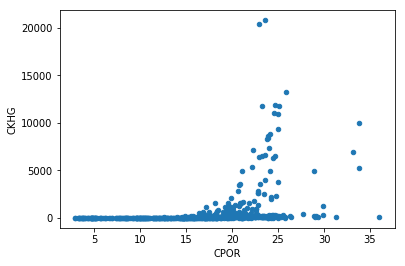

In [5]:
core_data.plot(kind="scatter", x="CPOR", y="CKHG")


From this scatter plot we notice that there is a large concentration of points at low permeabilities with a few points at the higher end. We can tidy up our plot by converting the y axis to a logaritmic scale and adding a grid. This generates the the poro-perm crossplot that we are familiar with in petrophysics.

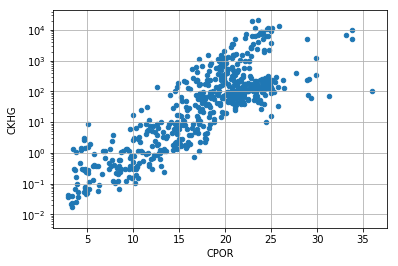

In [6]:
core_data.plot(kind="scatter", x="CPOR", y="CKHG")
plt.yscale('log')
plt.grid(True)


We can agree that this looks much better now. We can further tidy up the plot by:
* Switching to matplotlib for making out plot
* Adding labels by using ax.set_ylabel() and ax.set_xlabel()
* Setting ranges for the axis using ax.axis([0,40, 0.01, 100000)
* Making the y-axis values easier to read by converting the exponential notation to full numbers. This is done using FuncFormatter from matplotlib and setting up a simple for loop

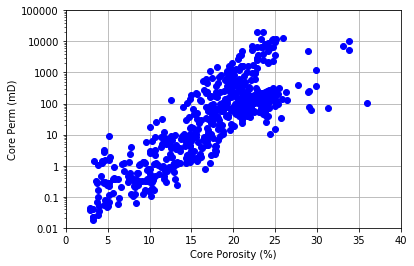

In [7]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 40, 0.01, 100000])
ax.plot(core_data['CPOR'], core_data['CKHG'], 'bo')
ax.set_yscale('log')
ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)
    
plt.savefig('11-xplot-semi-log-fixed.png', dpi=300)

Isn't that much better than the previous plot? We can now use this nicer looking plot within a petrophysical report or passing to other subsurface people within the team.

## Deriving Relationship Between Porosity and Permeability
There are two ways that we can carry out a poro-perm regression on our data:
* Using numpy's polyfit function
* Applying a regression using the statsmodels library

Before we explore each option, we first have to create a copy of our dataframe and remove the null rows. Carrying out the regression with NaN values can result in errors.

In [8]:
poro_perm = core_data[['CPOR', 'CKHG']].copy()

Once it has been copied we can then drop the NaNs using dropna(). Including the argument inplace=True tells the method to replace the values in place rather than returning a copy of the dataframe.

In [9]:
poro_perm.dropna(inplace=True)

### Numpy polyfit()
The simplest option for applying a linear regression through the data is using the polynomial fit function from numpy. This returns an array of co-efficients. As we are wanting to use a linear fit we can specify a value of 1 at the end of the function. This tells the function we want a first degree polynomial.  
  
Also, are we are dealing with permeability data in the logarithmic scale, we need to take the logarithm of the values using np.log10.

In [10]:
poro_perm_polyfit = np.polyfit(poro_perm['CPOR'], np.log10(poro_perm['CKHG']), 1)

In [11]:
poro_perm_polyfit

array([ 0.17428705, -1.55607816])

The first value is our slope and the second is our y-intercept.  
  
Polyfit doesn't give us much more information about the regression such as the co-efficient of determination (R-squared). For this we need to look at another model.

### Statsmodels Linear Regression
The second option for generating a poro-perm linear regression is to use the Ordinary Least Squares (OLS) method from the statsmodels library.   
  
First we need to import the library and create our data. We will assign our x value as Core Porosity (CPOR) and our y value as the log10 of Core Permeability (CKH). The y value will be the one we are aiming to build our prediction model from.  
  
With the statsmodel OLS we need to add a constant column to our data as an intercept is not included by default unless we are using formulas. See here for the documentation.

In [42]:
import statsmodels.api as sm

x = core_data['CPOR']
x = sm.add_constant(x)
y = np.log10(core_data['CKHG'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


We can confirm the values of x by calling upon it and in Jupyter it will return a dataframe as seen here:

In [43]:
x

,const,CPOR
0,1.0,17.0
1,1.0,14.8
2,1.0,10.8
3,1.0,12.8
4,1.0,NaN
...,...,...
723,1.0,28.9
724,1.0,20.7
725,1.0,20.9
726,1.0,17.3


The next step is to build and fit our model. With the OLS method, we can supply an argument for missing values. In this example I have set it to drop. This will remove or drop the missing values from the data.

In [23]:
model = sm.OLS(y, x, missing='drop')
results = model.fit()

Once we have fitted the model, we can view a full summary of the regression by calling upon `.summary()`  
  
  Which returns a nicely formatted table like the one below and includes key statistics as the R-squared and standard error.

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CKHG   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1340.
Date:                Wed, 30 Dec 2020   Prob (F-statistic):          4.26e-150
Time:                        13:07:14   Log-Likelihood:                -601.06
No. Observations:                 557   AIC:                             1206.
Df Residuals:                     555   BIC:                             1215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5561      0.088    -17.768      0.000      -1.728      -1.384
CPOR           0.1743      0.005     36.602      0.000       0.165       0.184
==============================================================================
Omnibus:                        6.685   Durbin-Watson:                   0.853
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.790
Skew:                           0.254   Prob(JB):                       0.0335
Kurtosis:                       2.816   Cond. No.                         53.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also obtain the key parameters: slope and intercept, by calling upon `results.params`.

In [45]:
results.params

const   -1.556078
CPOR     0.174287
dtype: float64

If we want to access one of the parameters, for example the slope or constant for the CPOR value, we can access it like a list:

In [46]:
results.params[1]

0.1742870473595357

Finally, we can take our equation and apply it to our scatter plot.

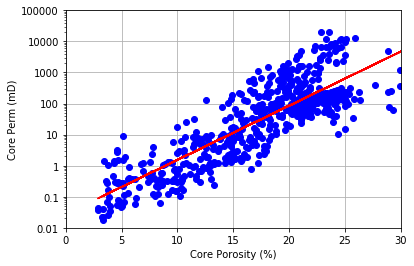

In [48]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 30, 0.01, 100000])
ax.semilogy(core_data['CPOR'], core_data['CKHG'], 'bo')

ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

ax.semilogy(core_data['CPOR'], 10**(results.params[1] * core_data['CPOR'] + results.params[0]), 'r-')

#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)
    
plt.savefig('predicted_poro_perm_xplot.png', dpi=100)


## Predicting a Continuous Permeability from Log Porosity
Now that we have our equation and we are happy with the results, we can apply this to our log porosity to generate a continuous permeability curve.  
  
First, we need to load in the well log data for this well:

In [18]:
well = pd.read_csv('Data/15_9-19.csv', skiprows=[1])

When we check the well header using well.head()we can see our newly created curve at the end of the dataframe:

In [19]:
well.head()

,DEPTH,CALI,COAL,DT,DT_LOG,DTS,DTS_LOG,GR,NPHI,PHIE,PHIEC,PHIT,PHITC,RHOB,RHOB_LOG,RT,RW,TEMP
0,3500.0183,9.315,0,76.7292,76.7292,157.1754,157.1754,36.621,0.1542,0.1122,0.1098,0.1209,0.1186,2.4602,2.460,1.791,0.0211,94.5855
1,3500.1707,9.324,0,77.2473,77.2473,158.9566,158.9566,36.374,0.1694,0.1074,0.1060,0.1159,0.1146,2.4680,2.468,1.756,0.0211,94.5897
2,3500.3231,9.338,0,77.8462,77.8462,159.7642,159.7642,30.748,0.1776,0.1082,0.1079,0.1127,0.1125,2.4730,2.473,1.720,0.0211,94.5940
3,3500.4755,9.329,0,78.3571,78.3571,158.7547,158.7547,29.795,0.1767,0.1254,0.1226,0.1292,0.1264,2.4471,2.447,1.696,0.0211,94.5982
4,3500.6279,9.328,0,78.6560,78.6560,157.1320,157.1320,27.346,0.1662,0.1278,0.1249,0.1299,0.1270,2.4460,2.446,1.697,0.0211,94.6025


In [20]:
well['PERM']= 10**(results.params[1] * (well['PHIT']*100) + results.params[0])

In [21]:
well.head()

,DEPTH,CALI,COAL,DT,DT_LOG,DTS,DTS_LOG,GR,NPHI,PHIE,PHIEC,PHIT,PHITC,RHOB,RHOB_LOG,RT,RW,TEMP,PERM
0,3500.0183,9.315,0,76.7292,76.7292,157.1754,157.1754,36.621,0.1542,0.1122,0.1098,0.1209,0.1186,2.4602,2.460,1.791,0.0211,94.5855,3.556741
1,3500.1707,9.324,0,77.2473,77.2473,158.9566,158.9566,36.374,0.1694,0.1074,0.1060,0.1159,0.1146,2.4680,2.468,1.756,0.0211,94.5897,2.910105
2,3500.3231,9.338,0,77.8462,77.8462,159.7642,159.7642,30.748,0.1776,0.1082,0.1079,0.1127,0.1125,2.4730,2.473,1.720,0.0211,94.5940,2.559392
3,3500.4755,9.329,0,78.3571,78.3571,158.7547,158.7547,29.795,0.1767,0.1254,0.1226,0.1292,0.1264,2.4471,2.447,1.696,0.0211,94.5982,4.962614
4,3500.6279,9.328,0,78.6560,78.6560,157.1320,157.1320,27.346,0.1662,0.1278,0.1249,0.1299,0.1270,2.4460,2.446,1.697,0.0211,94.6025,5.103999


## Visualising the Final Predicted Curve
The final step in our workflow is to plot the PHIT curve and the predicted permeability curve on a log plot alongside the core measurements.  
  
  This generates a simple two track log plot with our core measurements represented by black dots and our continuous curves by blue lines.

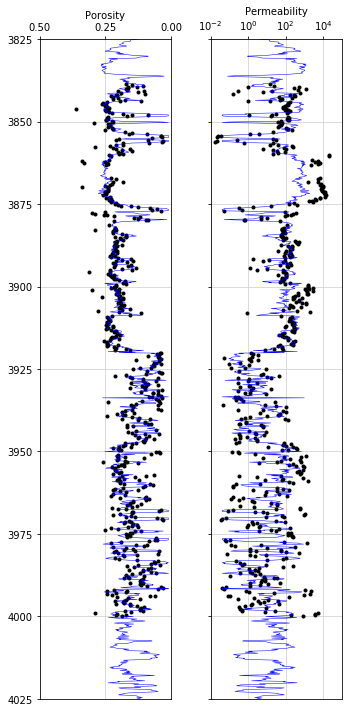

In [48]:
fig, ax = plt.subplots(figsize=(5,10))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

# Porosity track
ax1.plot(core_data["CPOR"]/100, core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax1.plot(well['PHIT'], well['DEPTH'], color ='blue', linewidth=0.5)
ax1.set_xlabel("Porosity")
ax1.set_xlim(0.5, 0)
ax1.xaxis.label.set_color("black")
ax1.tick_params(axis='x', colors="black")
ax1.spines["top"].set_edgecolor("black")
ax1.set_xticks([0.5,  0.25, 0])

# Permeability track
ax2.plot(core_data["CKHG"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax2.plot(well['PERM'], well['DEPTH'], color ='blue', linewidth=0.5)
ax2.set_xlabel("Permeability")
ax2.set_xlim(0.1, 100000)
ax2.xaxis.label.set_color("black")
ax2.tick_params(axis='x', colors="black")
ax2.spines["top"].set_edgecolor("black")
ax2.set_xticks([0.01, 1, 10, 100, 10000])
ax2.semilogx()

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2]:
    ax.set_ylim(4025, 3825)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
# Removes the y axis labels on the second track
for ax in [ax2]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.3)
plt.savefig('final_track_plot.png', dpi=100)

As seen in track 2, our predicted permeability from a simple linear regression tracks the core permeability reasonably well. However, between about 3860 and 3875, our prediction reads lower than the actual core measurements. Also, it becomes harder to visualise the correlation at the lower interval to the more thinly bedded nature of the geology.  
  
  We can build up a final plot like so.

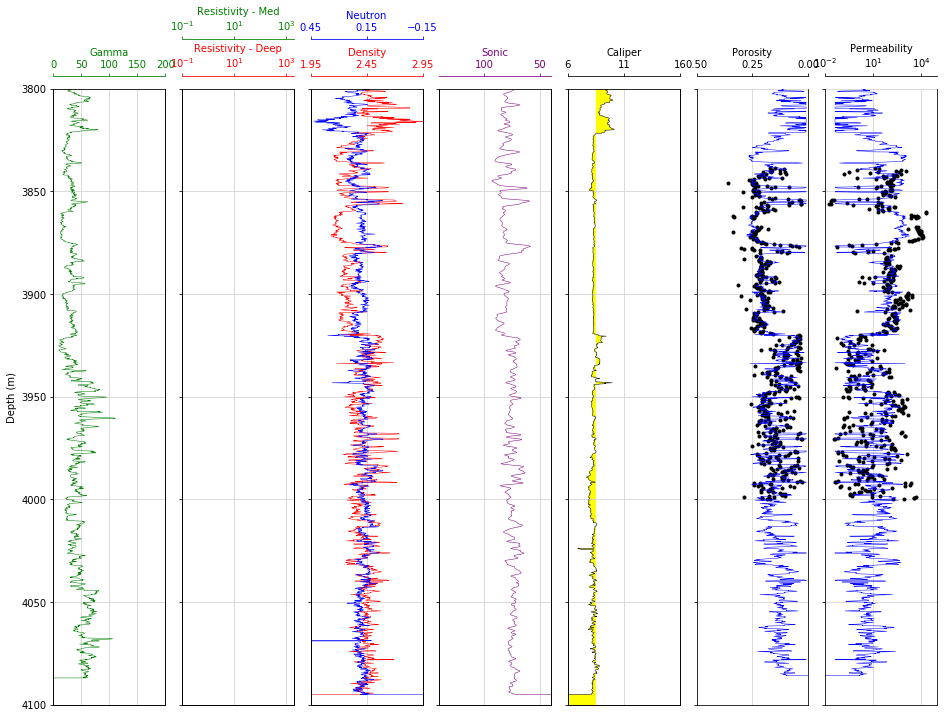

In [36]:
fig, ax = plt.subplots(figsize=(15,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,8), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,8), (0,1), rowspan=1, colspan = 1, sharey = ax1)
ax3 = plt.subplot2grid((1,8), (0,2), rowspan=1, colspan = 1, sharey = ax1)
ax4 = plt.subplot2grid((1,8), (0,3), rowspan=1, colspan = 1, sharey = ax1)
ax5 = ax3.twiny() #Twins the y-axis for the density track with the neutron track
ax6 = plt.subplot2grid((1,8), (0,4), rowspan=1, colspan = 1, sharey = ax1)
ax7 = ax2.twiny()
ax8 = plt.subplot2grid((1,8), (0,5), rowspan=1, colspan = 1, sharey = ax1)
ax9 = plt.subplot2grid((1,8), (0,6), rowspan=1, colspan = 1, sharey = ax1)

# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax10 = ax1.twiny()
ax10.xaxis.set_visible(False)
ax11 = ax2.twiny()
ax11.xaxis.set_visible(False)
ax12 = ax3.twiny()
ax12.xaxis.set_visible(False)
ax13 = ax4.twiny()
ax13.xaxis.set_visible(False)
ax14 = ax6.twiny()
ax14.xaxis.set_visible(False)

# Gamma Ray track
ax1.plot(well["GR"], well['DEPTH'], color = "green", linewidth = 0.5)
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")
ax1.set_xlim(0, 200)
ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150, 200])

# Resistivity track
# ax2.plot(well["RDEP"], well['DEPTH'], color = "red", linewidth = 0.5)
ax2.set_xlabel("Resistivity - Deep")
ax2.set_xlim(0.2, 2000)
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
ax2.set_xticks([0.1, 1, 10, 100, 1000])
ax2.semilogx()

# Density track
ax3.plot(well["RHOB"], well['DEPTH'], color = "red", linewidth = 0.5)
ax3.set_xlabel("Density")
ax3.set_xlim(1.95, 2.95)
ax3.xaxis.label.set_color("red")
ax3.tick_params(axis='x', colors="red")
ax3.spines["top"].set_edgecolor("red")
ax3.set_xticks([1.95, 2.45, 2.95])

# Sonic track
ax4.plot(well["DT"], well['DEPTH'], color = "purple", linewidth = 0.5)
ax4.set_xlabel("Sonic")
ax4.set_xlim(140, 40)
ax4.xaxis.label.set_color("purple")
ax4.tick_params(axis='x', colors="purple")
ax4.spines["top"].set_edgecolor("purple")

# Neutron track placed ontop of density track
ax5.plot(well["NPHI"], well['DEPTH'], color = "blue", linewidth = 0.5)
ax5.set_xlabel('Neutron')
ax5.xaxis.label.set_color("blue")
ax5.set_xlim(0.45, -0.15)
ax5.tick_params(axis='x', colors="blue")
ax5.spines["top"].set_position(("axes", 1.08))
ax5.spines["top"].set_visible(True)
ax5.spines["top"].set_edgecolor("blue")
ax5.set_xticks([0.45,  0.15, -0.15])

# Caliper track
ax6.plot(well["CALI"], well['DEPTH'], color = "black", linewidth = 0.5)
ax6.set_xlabel("Caliper")
ax6.set_xlim(6, 16)
ax6.xaxis.label.set_color("black")
ax6.tick_params(axis='x', colors="black")
ax6.spines["top"].set_edgecolor("black")
ax6.fill_betweenx(well['DEPTH'], 8.5, well["CALI"], facecolor='yellow')
ax6.set_xticks([6,  11, 16])

# Resistivity track - Curve 2
# ax7.plot(well["RMED"], well['DEPTH'], color = "green", linewidth = 0.5)
ax7.set_xlabel("Resistivity - Med")
ax7.set_xlim(0.2, 2000)
ax7.xaxis.label.set_color("green")
ax7.spines["top"].set_position(("axes", 1.08))
ax7.spines["top"].set_visible(True)
ax7.tick_params(axis='x', colors="green")
ax7.spines["top"].set_edgecolor("green")
ax7.set_xticks([0.1, 1, 10, 100, 1000])
ax7.semilogx()

# Porosity track
ax8.plot(core_data["CPOR"]/100, core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax8.plot(well['PHIT'], well['DEPTH'], color ='blue', linewidth=0.5)
ax8.set_xlabel("Porosity")
ax8.set_xlim(0.5, 0)
ax8.xaxis.label.set_color("black")
ax8.tick_params(axis='x', colors="black")
ax8.spines["top"].set_edgecolor("black")
ax8.set_xticks([0.5,  0.25, 0])

# Permeability track
ax9.plot(core_data["CKHG"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax9.plot(well['PERM'], well['DEPTH'], color ='blue', linewidth=0.5)
ax9.set_xlabel("Permeability")
ax9.set_xlim(0.1, 100000)
ax9.xaxis.label.set_color("black")
ax9.tick_params(axis='x', colors="black")
ax9.spines["top"].set_edgecolor("black")
ax9.set_xticks([0.01, 1, 10, 100, 10000])
ax9.semilogx()

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax3, ax4, ax6, ax8, ax9]:
    ax.set_ylim(4100, 3800)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
for ax in [ax2, ax3, ax4, ax6, ax8, ax9]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.15)

## Conclusion
In this walkthrough, we have covered what core porosity and permeability area and how we can predict the latter from the former to generate an equation that can be used to predict a continuous curve. This can subsequently be used in geological models or reservoir simulations.
As noted at the end, there are a few small mismatches. These would benefit from further investigation and potentially further modelling either by refining the regression or by applying another machine learning model.